In [1]:
name_subj = "B1_EEG"

import mne
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
EEG_data_path = '../data/B1/'#Path data is


# Reading raw BDF, setting up bipolar references and montage

In [2]:
raw = mne.io.read_raw_bdf(EEG_data_path+'%s.bdf'%name_subj,preload=True, verbose=True)

Extracting EDF parameters from /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B1/B1_EEG.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5910527  =      0.000 ...  2886.000 secs...


In [3]:
raw.info

Measurement date,"May 29, 2024 14:08:13 GMT"
Experimenter,Unknown
Participant,B1
Digitized points,Not available
Good channels,"72 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


- Good channels : 72 electrodes total (including the extrenal ones) + 1 stimulus (the trigger channel)

- Bad channels can be completed if needed

- EOG will be

- ECG is used in MEG

In [4]:
#raw.pick_channels(['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz','EXG1','EXG2','EXG3','EXG4','Status'])
# Creating the bipolar montage, the 4 first are the EOG
# ???? mne.set_bipolar_reference(raw,anode=['EXG1','EXG3'],cathode=['EXG2','A1'],ch_name=['EOGH','EOGV'],copy=False, drop_refs=False) 
raw.drop_channels(['EXG5','EXG6','EXG7', 'EXG8'])#Empty
raw.set_channel_types({'EXG1':'eog','EXG2':'eog','EXG3':'misc','EXG4':'misc'})#declare type to avoid confusion with EEG channels
raw.set_montage('biosemi64')

/tmp/ipykernel_74383/3219339146.py:5: RuntimeWarning: The unit for channel(s) EXG3, EXG4 has changed from V to NA.
  raw.set_channel_types({'EXG1':'eog','EXG2':'eog','EXG3':'misc','EXG4':'misc'})#declare type to avoid confusion with EEG channels


Measurement date,"May 29, 2024 14:08:13 GMT"
Experimenter,Unknown
Participant,B1
Digitized points,67 points
Good channels,"64 EEG, 2 EOG, 2 misc, 1 Stimulus"
Bad channels,None
EOG channels,"EXG1, EXG2"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


# Checking for bad electrodes

In [5]:
%matplotlib qt
# Double click on electrode, it gets grey and is added to 'bad channels' 
# In the interactive plot 'Status' is the trigger channel
raw.plot(block=True, scalings=100e-6);

Using qt as 2D backend.
Channels marked as bad:
none


# Referencing

In [6]:
# Ref to the average
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,"mai 29, 2024 14:08:13 GMT"
Experimenter,Unknown
Participant,B1
Digitized points,67 points
Good channels,"64 EEG, 2 EOG, 2 misc, 1 Stimulus"
Bad channels,None
EOG channels,"EXG1, EXG2"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


# Filtering

High pass filter

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Filter length: 675841 samples (330.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_74383/3420238711.py:7: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(tmin=500, fmax=200, picks='eeg'); # fmax to 200 when not as downsampled
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


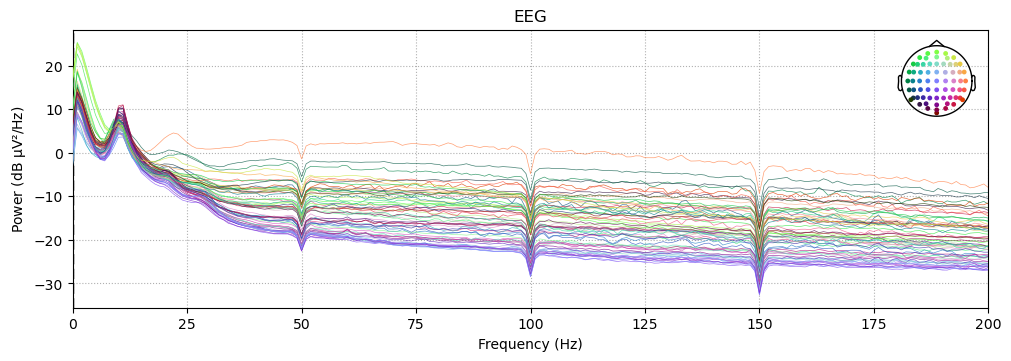

In [7]:
%matplotlib inline 
#bandpass filter
raw.filter(l_freq =.01, h_freq = None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') # high-pass filter to keep >.01 Hz
#Against electric noise of 50hz
raw.notch_filter(freqs=[50,100,150]) # add 150 when less downsampled
# Fourier to check filtering
raw.plot_psd(tmin=500, fmax=200, picks='eeg'); # fmax to 200 when not as downsampled
plt.show()

# Rejecting breaks

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1728 events found on stim channel Status
Event IDs: [3 4 5]


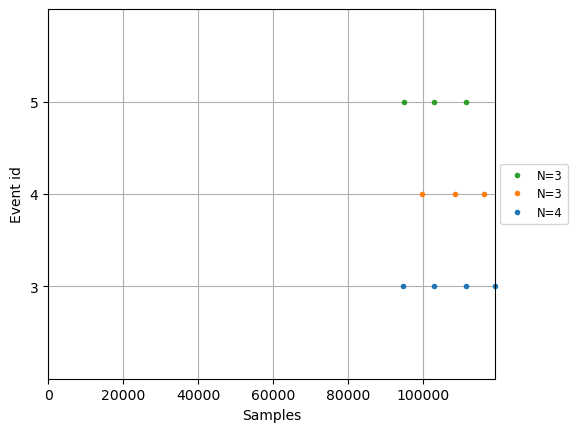

In [8]:
events = mne.find_events(raw, shortest_event=1, mask=0b11111111) # mask keeps only the first 8 bits of the triggers
mne.viz.plot_events(events[:10]);

In [9]:
cueoffset_trigger = [5]
cueonset_trigger = [3]
resp_trigger = [4]
stim = np.array([x for x in events if x[-1] in  cueonset_trigger])
resp = np.array([x for x in events if x[-1] in  resp_trigger])


## Interblock removal

In [10]:
stim_events = np.array([list(x) for x in events if x[2] in cueonset_trigger]) # detection based on time between consecutive cues onsets

precue_durmax = 1.25
betweencues_durmax = 7

estimated_duration_breaks = betweencues_durmax #seconds between two cues

# Detect breaks
onset_breaks = stim_events[np.where(np.diff(stim_events[:,0], n=1) > (raw.info['sfreq']*estimated_duration_breaks))][:,0]/raw.info['sfreq'] #detecting latencies 
offset_breaks = np.flip(np.flip(stim_events)[np.where(np.diff(np.flip(stim_events[:,0]), n=1) < -(raw.info['sfreq']*estimated_duration_breaks))])[:,0]/raw.info['sfreq']

# Adjust the removed window
# Breaks in general
onset_breaks = onset_breaks + betweencues_durmax # time at which the break comment will be added
offset_breaks = offset_breaks - precue_durmax # time at which the break comment will end

# First break
onset_breaks = np.insert(onset_breaks,0,0)
offset_breaks = np.insert(offset_breaks,0,stim_events[0,0]/raw.info['sfreq']-precue_durmax)

# Last break
onset_breaks = np.insert(onset_breaks,-1, stim_events[-1,0]/raw.info['sfreq']+betweencues_durmax)
offset_breaks = np.insert(offset_breaks,-1, raw.times.max())


duration_breaks = np.asarray(offset_breaks) - np.asarray(onset_breaks)


print(f'{len(duration_breaks)} breaks detected')
break_annot = mne.Annotations(onset= np.insert(onset_breaks,0,0),#just adding start of the recording to the breaks
                           duration=np.insert(duration_breaks,0, stim_events[0,0]/raw.info['sfreq']-1),
                           description=['BAD_breaks'])
raw.set_annotations(break_annot)

17 breaks detected


Measurement date,"mai 29, 2024 14:08:13 GMT"
Experimenter,Unknown
Participant,B1
Digitized points,67 points
Good channels,"64 EEG, 2 EOG, 2 misc, 1 Stimulus"
Bad channels,None
EOG channels,"EXG1, EXG2"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.01 Hz
Lowpass,417.00 Hz


In [11]:
raw.save(EEG_data_path+'/preprocessing/pre_ica_%s.fif'%name_subj,overwrite=True)

Overwriting existing file.
Writing /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/notebooks/../data/B1/preprocessing/pre_ica_B1_EEG.fif


/tmp/ipykernel_74383/1425496323.py:1: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/notebooks/../data/B1/preprocessing/pre_ica_B1_EEG.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(EEG_data_path+'/preprocessing/pre_ica_%s.fif'%name_subj,overwrite=True)


Closing /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/notebooks/../data/B1/preprocessing/pre_ica_B1_EEG.fif
[done]


# ICA

In [2]:
raw = mne.io.read_raw_fif(EEG_data_path+'/preprocessing/pre_ica_%s.fif'%name_subj, preload=True)

Opening raw data file ../data/B1//preprocessing/pre_ica_B1_EEG.fif...


/tmp/ipykernel_76072/4157375960.py:1: RuntimeWarning: This filename (../data/B1//preprocessing/pre_ica_B1_EEG.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(EEG_data_path+'/preprocessing/pre_ica_%s.fif'%name_subj, preload=True)


    Range : 0 ... 5910527 =      0.000 ...  2886.000 secs
Ready.
Reading 0 ... 5910527  =      0.000 ...  2886.000 secs...


In [3]:
#High pass filter before ICA as recommended by MNE
raw.filter(l_freq=1, h_freq=None)

# Reload triggers
events = mne.find_events(raw, shortest_event=1, mask=0b11111111) # mask keeps only the first 8 bits of the triggers
cueoffset_trigger = [5]
cueonset_trigger = [3]
resp_trigger = [4]
stim = np.array([x for x in events if x[-1] in  cueonset_trigger])
resp = np.array([x for x in events if x[-1] in  resp_trigger])


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1728 events found on stim channel Status
Event IDs: [3 4 5]


In [4]:
# ica = mne.preprocessing.ICA(n_components = len(raw.pick_types(eeg=True).ch_names)-1, method='fastica', max_iter='auto')
# ica.fit(raw)
ica = mne.preprocessing.read_ica(EEG_data_path+'/preprocessing/ICA_object_%s-ica.fif'%name_subj)

Reading ../data/B1//preprocessing/ICA_object_B1_EEG-ica.fif ...
Now restoring ICA solution ...
Ready.


In [15]:
ica.save(EEG_data_path+'/preprocessing/ICA_object_%s-ica.fif'%name_subj, overwrite=True);

Writing ICA solution to /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/notebooks/../data/B1/preprocessing/ICA_object_B1_EEG-ica.fif...


### Visualizing on epochs

In [5]:
epochs = mne.Epochs(raw, events, event_id=[int(x) for x in cueonset_trigger], tmin=-1, tmax=2, preload=True, baseline=None)

Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 576 events and 6145 original time points ...
0 bad epochs dropped


### ICs epoch timecourse


In [8]:
%matplotlib qt
ica.plot_components(inst=epochs)

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 585x260 with 3 Axes>]

In [18]:
ica.plot_sources(epochs, block=False)

Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated


Waiting for Loading-Thread to finish... (max. 10 sec)


## Final exclusions of ICA components :

[0]
Applying ICA to Evoked instance
    Transforming to ICA space (63 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


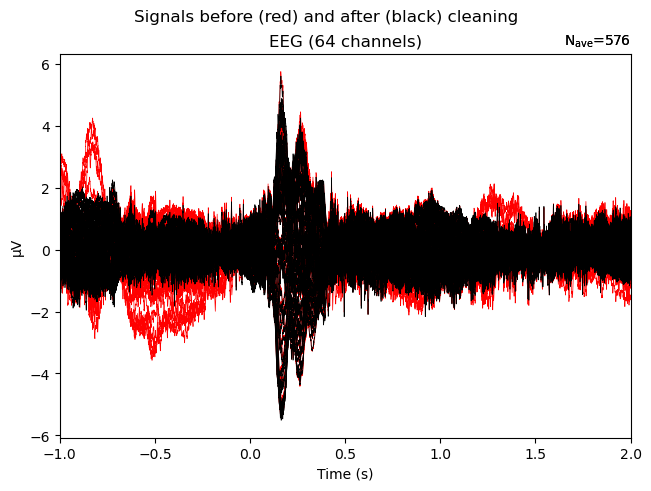

In [9]:
%matplotlib inline 
print(ica.exclude)
ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');

In [10]:
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


Measurement date,"mai 29, 2024 14:08:13 GMT"
Experimenter,Unknown
Participant,B1
Digitized points,67 points
Good channels,"64 EEG, 2 EOG, 2 misc, 1 Stimulus"
Bad channels,None
EOG channels,"EXG1, EXG2"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,1.00 Hz
Lowpass,417.00 Hz


# Interpolating the bad electrodes after ICA

In [11]:
print(raw.info['bads'])
raw = raw.interpolate_bads()
raw.info['bads']


[]
Setting channel interpolation method to {'eeg': 'spline'}.


/tmp/ipykernel_76072/2519011897.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.interpolate_bads()


[]

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 1380640 of 5910528 (23.36%) samples to NaN, retaining 4529888 (76.64%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/mne/time_frequency/psd.py:266: UserWarning: nperseg = 2048 is greater than input length  = 1, using nperseg = 1
  return _func(*args, **kwargs)
/tmp/ipykernel_76072/3395524401.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(fmax=80);
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


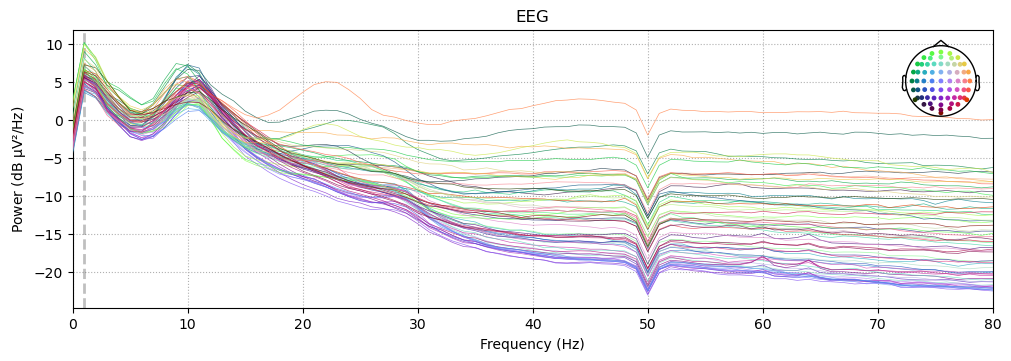

In [12]:
%matplotlib inline
raw.plot_psd(fmax=80);

In [ ]:
# raw.save(EEG_data_path+'/preprocessing/post_ica_%s_raw.fif'%name_subj,overwrite=True)

## Creating epochs

In [13]:
# raw = mne.io.read_raw_fif(EEG_data_path+'preprocessing/post_ica_%s_raw.fif'%name_subj, preload=True)
# Reload triggers
events = mne.find_events(raw, shortest_event=1, mask=0b11111111) # mask keeps only the first 8 bits of the triggers
cueoffset_trigger = [5]
cueonset_trigger = [3]
resp_trigger = [4]
stim = np.array([x for x in events if x[-1] in  cueonset_trigger])
resp = np.array([x for x in events if x[-1] in  resp_trigger])

tmin = -1 #tmin is how much data (in s) needs to be used for baseline correction
tmax = 2 #tmax is how much far in time from stim should we look for a response

# Applying a baseline correction from -1 to 0 
# Using a linear detrending as electrodes presents a strong drift
epochs = mne.Epochs(raw, stim,  event_id=[int(x) for x in cueonset_trigger], tmin=tmin, tmax=tmax, 
                baseline=(None, 0), preload=True, detrend=1)

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1728 events found on stim channel Status
Event IDs: [3 4 5]
Not setting metadata
576 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 576 events and 6145 original time points ...
0 bad epochs dropped


In [14]:
# Remove trials with artifacts in electrodes of interest
relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']

epochs.plot(picks=relevant_electrodes)

Using qt as 2D backend.


Dropped 3 epochs: 147, 347, 365
The following epochs were marked as bad and are dropped:
[147, 347, 365]
Channels marked as bad:
none


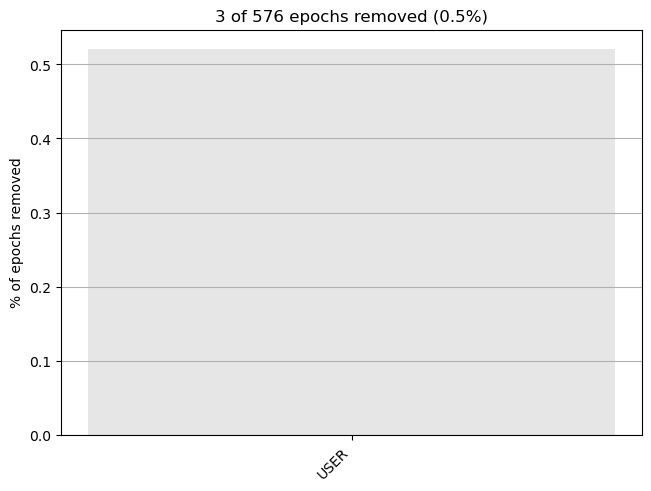

In [15]:
epochs.plot_drop_log();

In [16]:
epochs.save(EEG_data_path+'/preprocessing/%s_epo.fif'%name_subj, overwrite=True)